In [41]:
import pandas as pd
import numpy as np
import requests
import urllib

from sqlalchemy import create_engine

# Custom upload with connection string
from engine_info import server_info

import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams

In [65]:
rcParams['figure.figsize'] = 12,8

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [44]:
# Creating a connection to MS SQL SERVER
params = urllib.parse.quote_plus(server_info)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
connection = engine.connect()

In [45]:
# Upload sales data
sales = pd.read_sql_table('Joburg_Fresh_produce_combined_cleaned', connection)

## Data preparation

In [46]:
sales.head()

,rowid,date,commodity,container,unit_mass,product_combination,total_value_sold,total_qty_sold,total_kg_sold,average,highest_price,ave_per_kg,highest_price_per_kg
0,1,2020-08-20,AMADUMBE,20KG POCKET,20,"*,*,L,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0
1,2,2020-08-20,APPLES,10 X 1KG ECONO PACK CARTON,10,"GOLDEN DELICIOUS,CL 1,*,*,*",100.0,1,10.0,100.0,100.0,10.0,10.0
2,3,2020-08-20,APPLES,10 X 1KG ECONO PACK CARTON,10,"ROYAL GALA,CL 1,*,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0
3,4,2020-08-20,APPLES,11KG JUMBLE CARTON,11,"GOLDEN DELICIOUS,CL 2,L,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0
4,5,2020-08-20,APPLES,11KG JUMBLE CARTON,11,"TOPRED,CL 2,L,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0


In [47]:
len(sales)

55423

In [48]:
# Upload inventory data
inventory = pd.read_sql_table('Joburg_Fresh_produce_container_cleaned', connection)

In [49]:
inventory.head()

,rowid,date,commodity,container,qty_available,average_price_per_kg,MTD_total_value_sold_(R),total_value_sold_(R),Total_quatity_sold,MTD_Total_quatity_sold,Total_kg_sold,MTD_total_kg_sold
0,1,20 August 2020,AMADUMBE,20KG POCKET,2,0.00,39870.0,0.0,0.0,97.0,0.0,1940.0
1,2,20 August 2020,APPLES,10 X 1KG ECONO PACK CARTON,17,10.00,41932.0,100.0,1.0,547.0,10.0,5470.0
2,3,20 August 2020,APPLES,11KG JUMBLE CARTON,343,6.36,218914.0,1190.0,17.0,3170.0,187.0,34870.0
3,4,20 August 2020,APPLES,12 X 1KG ECONO PACK CARTON,3233,7.86,1454572.0,40738.0,432.0,17353.0,5184.0,208236.0
4,5,20 August 2020,APPLES,12.5KG M6 CARTON,12,0.00,16903.0,0.0,0.0,286.0,0.0,3575.0


For the purpose of this notebook, analysis will focus on potatoes.

In [50]:
inventory = inventory[inventory['commodity'] == 'APPLES']
sales = sales[sales['commodity'] == 'APPLES']

In [51]:
df = sales[sales['total_value_sold'] > 0]

In [52]:
df['container'].value_counts()

18.50KG CARTON                  1560
8 X 1.5KG ECONO PACK CARTON      798
9KG JUMBLE CARTON                713
12 X 1KG ECONO PACK CARTON       140
11KG JUMBLE CARTON               137
300KG BULK BIN                   100
3KG POCKET                        75
3 KG ECONO PACK BOX               22
6 X 1.5KG ECONO PACK CARTON       17
500G PUNNET PACK BOX               9
1.5KG ECONO PACK                   9
3KG ECONO PACK                     8
7 X 1.5 KG ECONO PACK CARTON       7
10 X 1KG ECONO PACK CARTON         7
11KG DOUBLE LAYER                  7
8 X 1 KG ECONO PACK CARTON         4
12.5KG M6 CARTON                   3
12.50KG MARK 9                     2
8KG BOX                            1
12.5KG M6 CONTAINER                1
5KG JUMBLE CARTON                  1
18 X 1KG ECONO PACK CARTON         1
18KG CARTON                        1
Name: container, dtype: int64

In [53]:
df[df['container'] == '18.50KG CARTON']['product_combination'].value_counts()

GOLDEN DELICIOUS,CL 1,*,100,*    27
GOLDEN DELICIOUS,CL 1,*,80,*     26
FUJI,CL 1,*,80,*                 26
STARKING,CL 1,*,80,*             26
GOLDEN DELICIOUS,CL 1,*,90,*     26
                                 ..
AFRICAN CARMINE,CL 1,*,110,*      1
PINK LADY,CL 1,*,90,*             1
GRANNY SMITH,CL 2,*,70,*          1
GRANNY SMITH,CL 1,*,165,*         1
TOPRED,CL 2,*,100,*               1
Name: product_combination, Length: 151, dtype: int64

In [54]:
# 10KG POCKET will be the focus of this notebook since it's the most active
len(df)

3623

In [55]:
filtered_df = df[(df['container'] == '18.50KG CARTON') & (df['product_combination'] == 'GOLDEN DELICIOUS,CL 1,*,100,*')]

In [56]:
filtered_df.head()

,rowid,date,commodity,container,unit_mass,product_combination,total_value_sold,total_qty_sold,total_kg_sold,average,highest_price,ave_per_kg,highest_price_per_kg
76,77,2020-08-20,APPLES,18.50KG CARTON,18,"GOLDEN DELICIOUS,CL 1,*,100,*",18270.0,104,1924.0,175.67,200.0,9.50,10.81
2240,2241,2020-08-21,APPLES,18.50KG CARTON,18,"GOLDEN DELICIOUS,CL 1,*,100,*",7998.0,43,795.5,186.00,200.0,10.05,10.81
4315,4316,2020-08-25,APPLES,18.50KG CARTON,18,"GOLDEN DELICIOUS,CL 1,*,100,*",17350.0,101,1868.5,171.78,190.0,9.29,10.27
5860,51428,2020-09-26,APPLES,18.50KG CARTON,18,"GOLDEN DELICIOUS,CL 1,*,100,*",4000.0,22,407.0,181.82,190.0,9.83,10.27
7810,53378,2020-09-28,APPLES,18.50KG CARTON,18,"GOLDEN DELICIOUS,CL 1,*,100,*",8100.0,45,832.5,180.00,200.0,9.73,10.81


In [57]:
price = filtered_df[['date', 'ave_per_kg']]

In [58]:
price.set_index('date', inplace=True)

In [59]:
price.head()

,ave_per_kg
date,
2020-08-20,9.50
2020-08-21,10.05
2020-08-25,9.29
2020-09-26,9.83
2020-09-28,9.73


In [60]:
price.sort_index(inplace=True)

In [61]:
price.index

DatetimeIndex(['2020-08-20', '2020-08-21', '2020-08-25', '2020-08-26',
               '2020-08-27', '2020-08-28', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-14',
               '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-19',
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-26', '2020-09-28', '2020-09-29'],
              dtype='datetime64[ns]', name='date', freq=None)

The freq of the index is currently set to None, this will need to be changed to daily, since the frequency of the data is daily. Furthermore, since there is no data available for weekends, the freq has to be set to Business day (Mon-Fri), with a backfill method to account for those days when it is a holiday and no data updated. 

In [62]:
price = price.asfreq('B', method='backfill')

In [63]:
price.index

DatetimeIndex(['2020-08-20', '2020-08-21', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-31',
               '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29'],
              dtype='datetime64[ns]', name='date', freq='B')

The index freq has been set to 'B' for business day with additional dates included like '2020-08-24' which the data was filled with the backfill method.

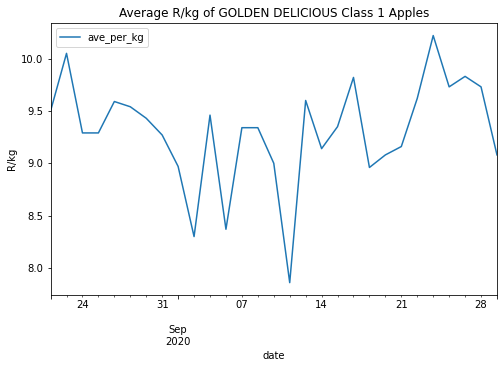

In [64]:
ax = price.plot(figsize=(8,5), title="Average R/kg of GOLDEN DELICIOUS Class 1 Apples")
ax.set(ylabel='R/kg');

## Introduction

Due to competition, retailers aim to increase profits and reduce costs, increasing the profit margin for perishable food products. This means that avoiding costs due to lost sales, and because of the short-shelf life of their products, ensuring that there is no build up of inventory. Effecient forecasting system can result in reduced inventory, be flexible to changes and increase profits. 

Time series forecasting uses past observations of the same variable to develop a model describing the underlying relationship. The model is then used to extrapolate time series into the future. This approach is useful when there are no other explanatory variables influencing the generation of the underlying data. 

### Trend

The Hodrick-Prescott filter is used to get the trend of the data. This approach separates the time-series into a trend component and a cyclical component.

In [66]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [67]:
# Tuple unpacking
price_cycle, price_trend = hpfilter(price)

In [68]:
price['trend'] = price_trend

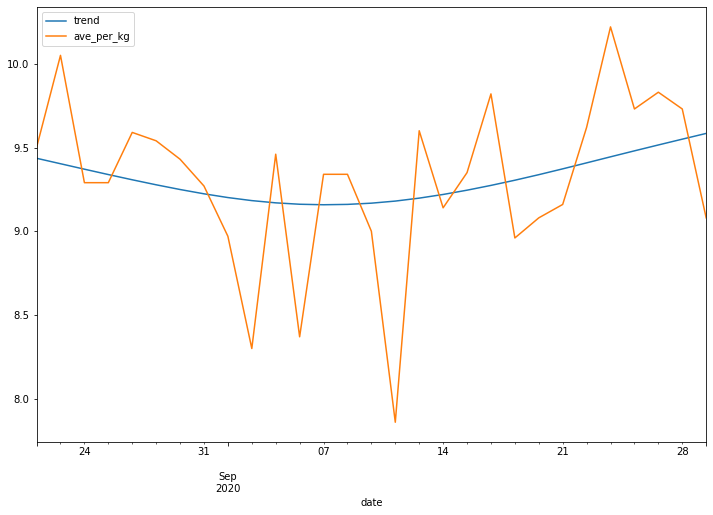

In [69]:
ax = price[['trend','ave_per_kg']].plot()
ax.autoscale(axis='x',tight=True);

Method will probably work better once data is viewed on a monthly basis. For now the approach is acknowledged.

In [70]:
del price['trend']

### Seasonal Decomposition

Time series decomposition involves the deconstruction of the time series data into the trend, seasonal and noise component.

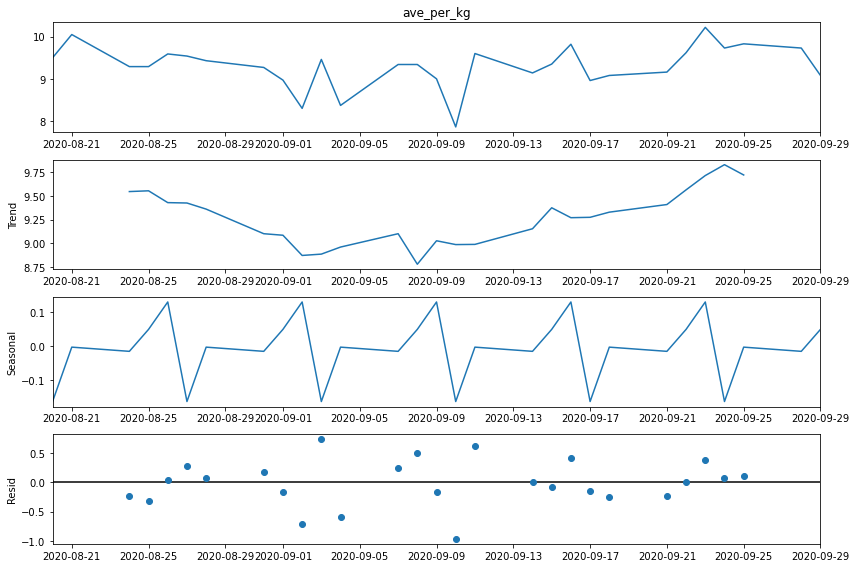

In [71]:
result = seasonal_decompose(price['ave_per_kg'], model='additive')  # model='mul' also works
result.plot();

From above, it can be seen that the trend component is much better than when using the Hodrick-Prescott filter. This might be due to the data having a daily frequency.

## Holt - Winters method

Holt - Winters method is a generalized exponential smooothing method that incorporates **trend** and **seasonal** variation in the model. The model makes use of exponential weighting of the coefficients of past observations in order to give more weight to the most recent observations. 

In [72]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [73]:
train_data = price.iloc[:-15]
test_data = price.iloc[-15:]

In [74]:
model = ExponentialSmoothing(train_data['ave_per_kg'], trend='add',seasonal='add',seasonal_periods=7) 
fitted_model = model.fit()

In [75]:
test_predictions = fitted_model.forecast(15).rename('Forecast')

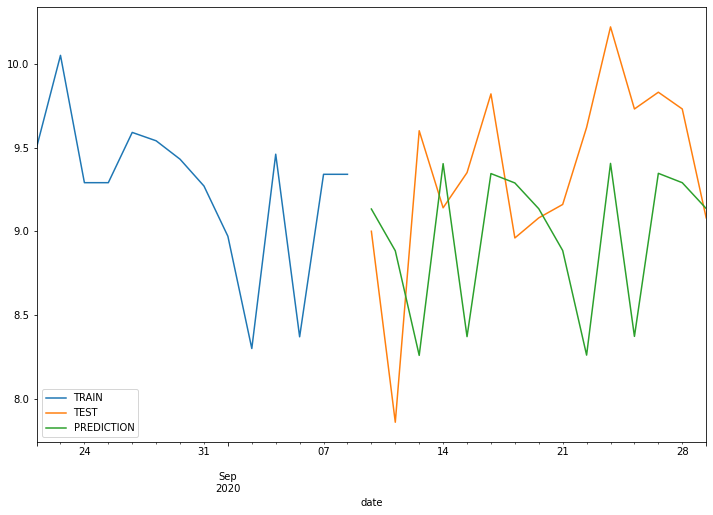

In [83]:
train_data['ave_per_kg'].plot(legend=True, label='TRAIN')
test_data['ave_per_kg'].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION');

In [77]:
from sklearn.metrics import mean_squared_error

In [78]:
hw_pred = np.sqrt(mean_squared_error(test_data, test_predictions))

In [79]:
hw_pred

0.7784460552212608

## Autoregressive (AR) model

The Holt-Winters method forecasts the variable of interest using a linear combination of predictors. These predictors are the set of level, trend and seasonal predictors. 

The autoregression model uses a linear combination of past values of the variable. This is a regression equation whereby the variable of interest is regressed against a set of it's lagged values of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

In [80]:
# Import AR model
from statsmodels.tsa.ar_model import AR

In [120]:
model = AR(train_data['ave_per_kg'])

### AR(1) model

In [121]:
ar1 = model.fit(maxlag=1)

In [122]:
# This is the general format for obtaining predictions
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions1 = ar1.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

### AR(2) model

In [123]:
model = AR(train_data['ave_per_kg'])
ar2 = model.fit(maxlag=2)
predictions2 = ar2.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

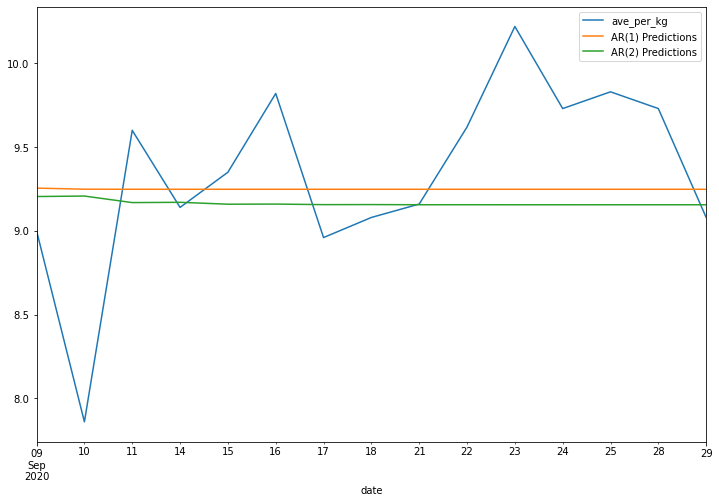

In [124]:
test_data['ave_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True);

### AR(5) model

In [125]:
model = AR(train_data['ave_per_kg'])
ar5 = model.fit(maxlag=5)
predictions5 = ar5.predict(start=start, end=end, dynamic=False).rename('AR(5) Predictions')

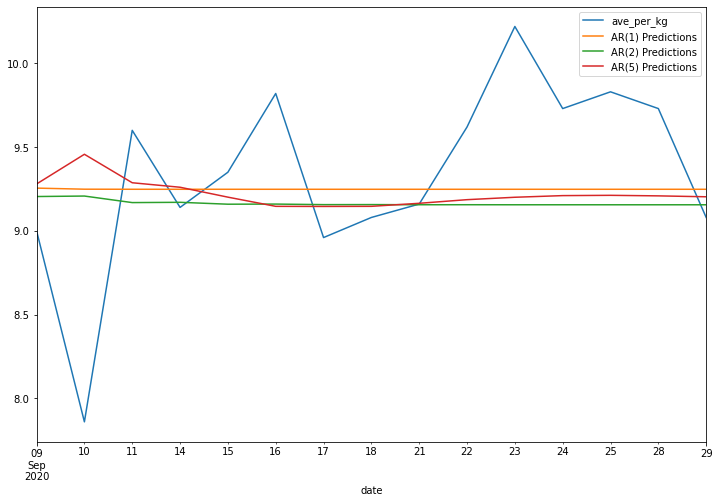

In [126]:
test_data['ave_per_kg'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions5.plot(legend=True);

In [127]:
# Identify the best AR(1) model to use for forecasting
model = AR(train_data['ave_per_kg'])
arfit = model.fit()

In [128]:
arfit.params

const            0.110193
L1.ave_per_kg   -1.203823
L2.ave_per_kg   -0.008387
L3.ave_per_kg    0.678704
L4.ave_per_kg   -1.024512
L5.ave_per_kg   -0.042869
L6.ave_per_kg    1.148917
L7.ave_per_kg    1.310785
dtype: float64

### AR(7) model

In [129]:
model = AR(train_data['ave_per_kg'])
ar7 = model.fit(maxlag=7)
predictions7 = ar7.predict(start=start, end=end, dynamic=False).rename('AR(7) Predictions')

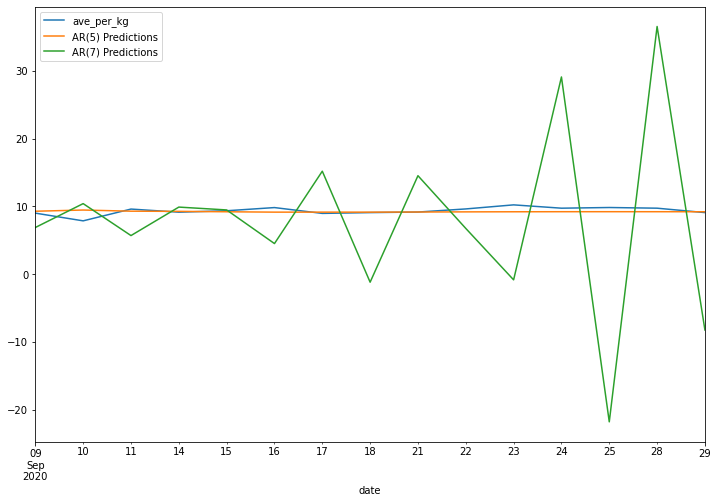

In [130]:
test_data['ave_per_kg'].plot(legend=True)
predictions5.plot(legend=True)
predictions7.plot(legend=True);

## Autoregressive Moving Average (ARMA) model

ARMA model is a combination of two models, the AR model utilizing past values of the time series data, and the Moving Average (MA) model, which uses past values of the forecast errors. As seen earlier, this models can be also be used separately, or in this section, combined.

## Autoregressive Integrated Moing Average (ARIMA) model